In [1]:
import itertools
import pandas as pd
from scipy import stats
import statsmodels.api as sm
%pylab inline

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("./WAG_C_M.csv", sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

# 1. Визуальный анализ ряда

Для начала посмотрим на датасет:

In [3]:
df.head(24)

WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5
1993-06-01     47.4
1993-07-01     56.0
1993-08-01     65.4
1993-09-01     80.9
1993-10-01     93.0
1993-11-01    101.5
1993-12-01    141.2
1994-01-01    134.2
1994-02-01    144.7
1994-03-01    164.8
1994-04-01    171.5
1994-05-01    183.5
1994-06-01    207.5
1994-07-01    221.0
1994-08-01    232.8
1994-09-01    253.2
1994-10-01    265.0
1994-11-01    281.6
1994-12-01    354.2

Рассмотрим график

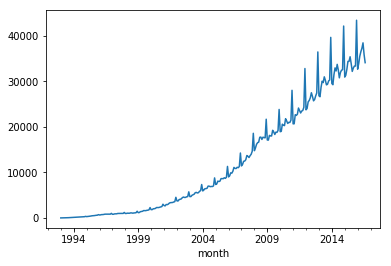

In [4]:
df.WAG_C_M.plot()

Согласно графику, ряд имеет сильную трендовую составляющую, и имеется сезонная составляющая.   
Также видно что имеется растущий размах колебаний, который можно трактовать как проявление гетерокседаксичности. 

Согласно расссмотренным особенностям графика, ряд является нестационарным.

<Figure size 1080x720 with 0 Axes>

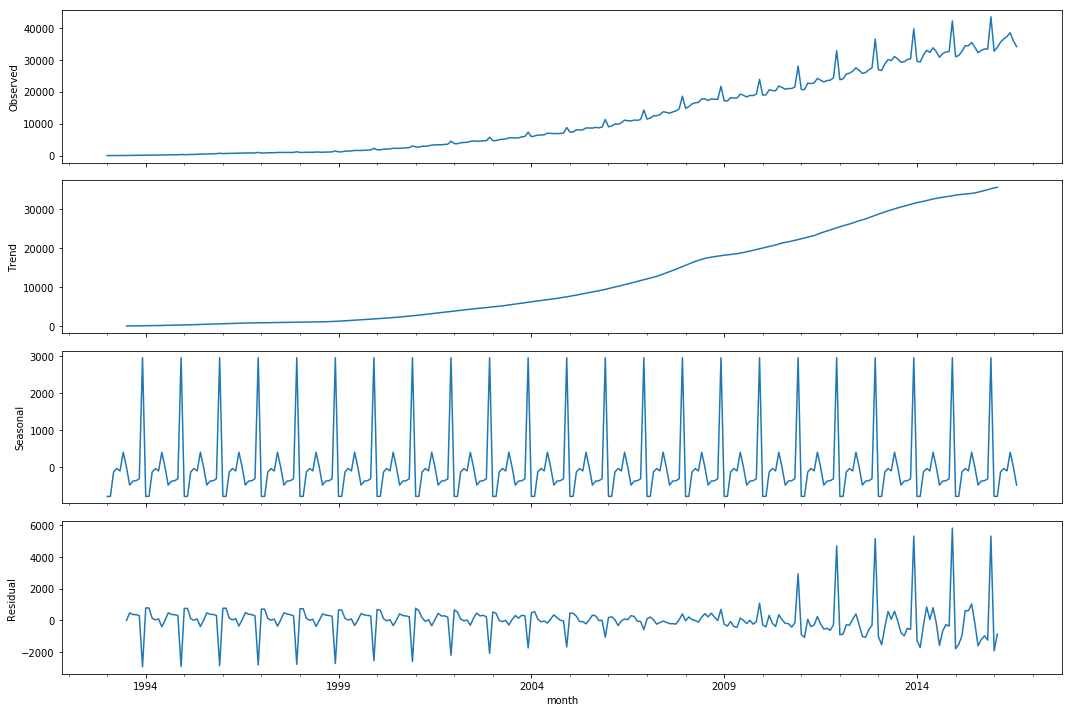

In [5]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(df.WAG_C_M).plot()

# 2. Стабилизация дисперсии (при необходимости)

Проверим необходимость и выберем оптимальное (приблизительно) значение ляимбда.

In [6]:
min_pvalue = 1.
min_lmd = None

def criteria(lmd):
    return sm.tsa.adfuller(stats.boxcox(df.WAG_C_M, lmbda=lmd))[1]

for lmd in [0., 0.1,0.25, 0.5, 1., 1.1, 1.25, 1.5, 1.75, 3.]:
    if min_lmd is None:
        min_lmd = lmd
        min_pvalue = criteria(lmd)
    else:
        pvalue = criteria(lmd)
        if pvalue < min_pvalue:
            min_lmd = lmd
            min_pvalue = pvalue

print "min lambda: ", min_lmd
print "min p-value", min_pvalue

min lambda:  0.0
min p-value 0.03401037411699181


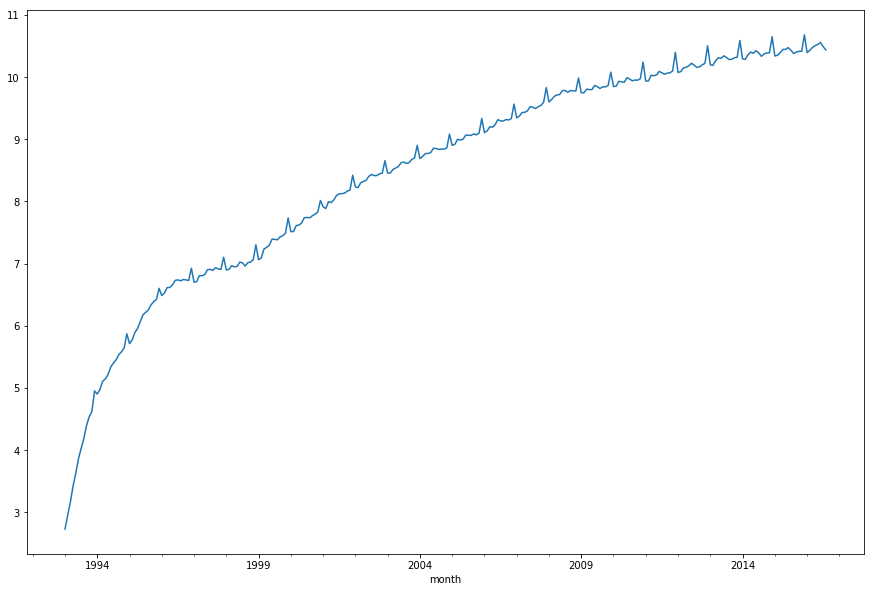

In [7]:
df["boxcox"] = stats.boxcox(df.WAG_C_M, lmbda=0.)
df["boxcox"].plot()

Подобранное значение лябда не равно 1, что говорит о необходимости преобразования. 

# 3. Выбор порядка дифференцирования

Проверим ряд на стационарность с помощью критерия Дики-Фуллера

In [8]:
sm.tsa.adfuller(df.boxcox)

(-3.00956915070421,
 0.03401037411699181,
 14,
 269,
 {'1%': -3.4548957220044336,
  '10%': -2.572527778361272,
  '5%': -2.8723451788613157},
 -1217.2355475245004)

p-value теста Дики-Фуллера меньше 5% уровня значимости, гипотеза о нестационарности отвергается. Но при простмотре графиков STL заметно наличие трендовой и сезонной компоненты. Поэтому проведем сезонное, а затем линейное дифференцирование.

In [9]:
df['box_D12'] = df.boxcox - df.boxcox.shift(12)

In [10]:
df['box_D12_d1'] = df.box_D12[12:] - df.box_D12[12:].shift(1)

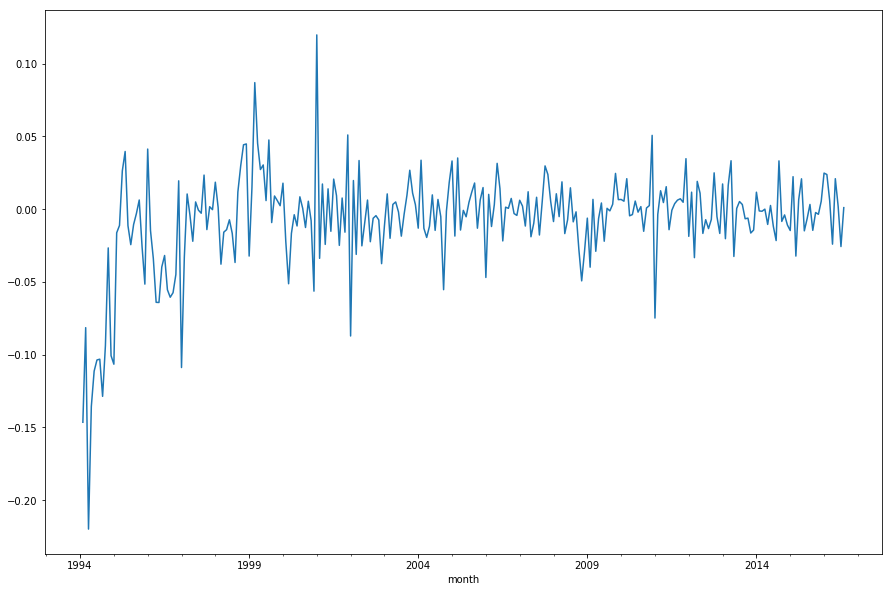

In [11]:
df['box_D12_d1'].plot()

После подбора параметров дифференцирования на графике исчезла сезонность и почти исчез тренд. Ряд визуально выглядик достаточно стационарным.

# 4. Выбор начальных приближений для p, q, P, Q

Построим автокорреляционную функцию

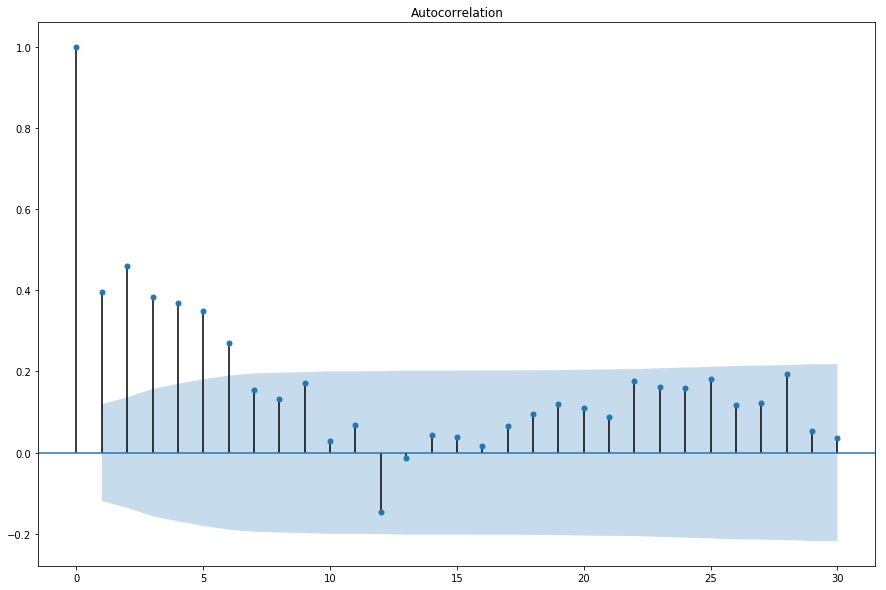

In [12]:
_ = sm.graphics.tsa.plot_acf(df.box_D12_d1[13:].values.squeeze(), lags=30)

Согласно автокорреляционной функции у ряда нету сезонности, поэтому Q будет равна нулю.
В качестве q выберем последний значимый лаг - 6.

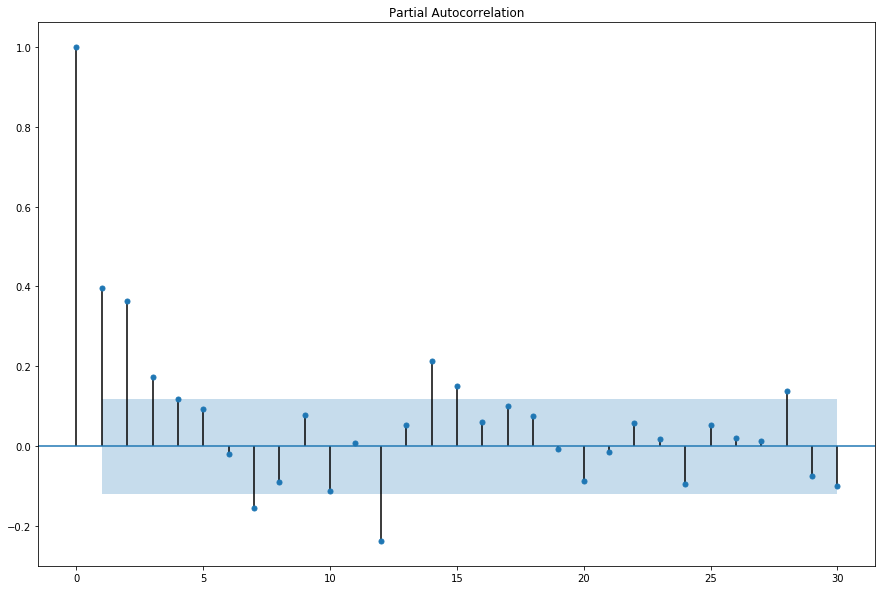

In [13]:
_ = sm.graphics.tsa.plot_pacf(df.box_D12_d1[13:].values.squeeze(), lags=30)

На ЧАКФ также нету значимой сезонности, поэтому P возьмем равным 0.
В качестве начального значения p возьмем 3.

# 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [14]:
ps = range(0, 4)
d = 1
qs = range(0, 3)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [15]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [16]:
def init_pPqQ(p,q,P,Q, d, D):
    param = (p, q, P, Q)
    aic = None
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.boxcox, 
            order=(
                param[0], 
                d, 
                param[1]
            ), 
            seasonal_order=(
                param[2], 
                D, 
                param[3], 
                12
            )
        ).fit(disp=-1)
        aic = model.aic
        return aic
    except ValueError:
        print('wrong parameters:', param)
        return None

In [27]:
%%time
results = []
best_aic = float("inf")
best_param = None
warnings.filterwarnings('ignore')

init_p = 6
init_q = 3
init_P = 0
init_Q = 0
init_aic = init_pPqQ(init_p, init_q, init_P, init_Q, 0, 0)

if init_aic is not None:
    best_aic = init_aic
    best_param = (init_p, init_q, init_P, init_Q)

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.boxcox, 
            order=(
                param[0], 
                d, 
                param[1]
            ), 
            seasonal_order=(
                param[2], 
                D, 
                param[3], 
                12
            )
        ).fit(disp=-1)
#         print('correct parameters:', param)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (6, 3, 0, 0))
CPU times: user 53.4 s, sys: 2.54 s, total: 56 s
Wall time: 56.7 s


Рассмотрим кандидатов:

In [18]:
print(results)

[[(0, 0, 0, 0), -1037.6610415341283], [(0, 0, 0, 1), -1040.4293643352921], [(0, 0, 1, 0), -1043.2133130780205], [(0, 0, 1, 1), -1050.8378041376031], [(0, 1, 0, 0), -1066.9240551848616], [(0, 1, 0, 1), -1074.7262888197074], [(0, 1, 1, 0), -1076.5480098659718], [(0, 1, 1, 1), -1077.70575291114], [(0, 2, 0, 0), -1097.4259126240029], [(0, 2, 0, 1), -1107.7957557092723], [(0, 2, 1, 0), -1108.954297481732], [(0, 2, 1, 1), -1106.0386957959345], [(1, 0, 0, 0), -1092.2916348371468], [(1, 0, 0, 1), -1109.3120932447878], [(1, 0, 1, 0), -1106.7563631511744], [(1, 0, 1, 1), -1109.7809412317804], [(1, 1, 0, 0), -1157.669332843243], [(1, 1, 0, 1), -1200.0525352888571], [(1, 1, 1, 0), -1192.1225553331901], [(1, 1, 1, 1), -1195.5885852872016], [(1, 2, 0, 0), -1167.2051401127537], [(1, 2, 0, 1), -1212.2605112874278], [(1, 2, 1, 0), -1207.1533783740988], [(1, 2, 1, 1), -1212.6459233410662], [(2, 0, 0, 0), -1134.9420110505675], [(2, 0, 0, 1), -1162.374601206346], [(2, 0, 1, 0), -1157.079633935553], [(2, 0

В качестве победителя выберем модель с параметрами p=0, q=0, P=4, Q=0, d=0, D=0.

In [19]:
best_param

(1, 2, 1, 1)

# 6. Анализ остатков построенной модели

Рассмотим лучшую модель

In [20]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 12)   Log Likelihood                 612.323
Date:                            Mon, 07 Jan 2019   AIC                          -1212.646
Time:                                    08:02:13   BIC                          -1191.033
Sample:                                01-01-1993   HQIC                         -1203.968
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9854      0.005    184.521      0.000       0.975       0.996
ma.L1         -0.9772      0.048    -20.173      0.000      -1.072      -0.882
ma.L2          0.2898      0.060      4.798      0.000       0.171       0.408
ar.S.L12       0.0694      0.109      0.637      0.524      -0.144       0.283
ma.S.L12      -0.5790      0.091     -6.363      0.000      -0.757      -0.401
sigma2         0.0006   4.38e-05     14.297      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       61.21   Jarque-Bera (JB):               127.21
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Критерий Стьюдента: p=0.271460
Критерий Дики-Фуллера: p=0.000000


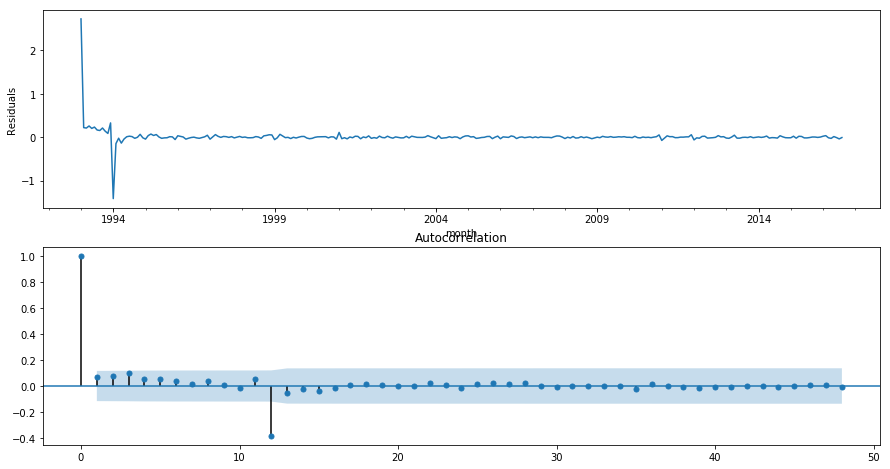

In [21]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Выбрав уровень знаимости 0.05, можно утверждать следующее:
Остатки стационарны согласно критерию Дикки-Фуллера, достигаемый уровень значемости пренебрежительно мал.
Остатки смещены согласно критерию Стьюдента, согласно тексту задания при построении прогноза нам потребеттся вычесть константу, в качестве константы возьмем среднее арифметическое от остатков. 

В примере временной ряд также не прошел тест Стьюдента, обсуждение данной проблемы можно посмотреть по созданному мною топику: https://www.coursera.org/learn/data-analysis-applications/discussions/weeks/1/threads/-9pXKxHUEemI2Arzs2jnSA

Также можно заключить, что данные неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

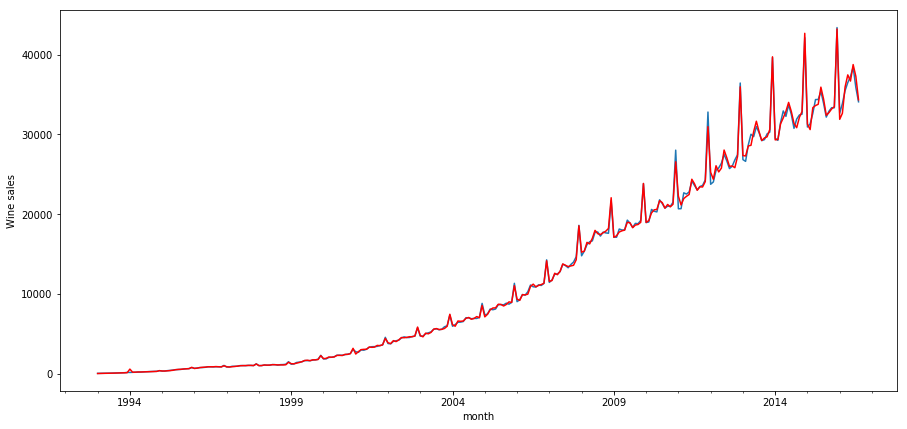

In [22]:
df['model'] = invboxcox(best_model.fittedvalues, 0)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Визуально, модель хорошо описывает временной ряд, при этом не потребовалось смещения смоделлированных значени на константу. 

Теперь проведем сравнение с учетом смещения смоделированного ряда. 

Будем смещать на следующую величину:

In [23]:
best_model.resid.mean()

0.012340443935006988

Рассмотрим график:

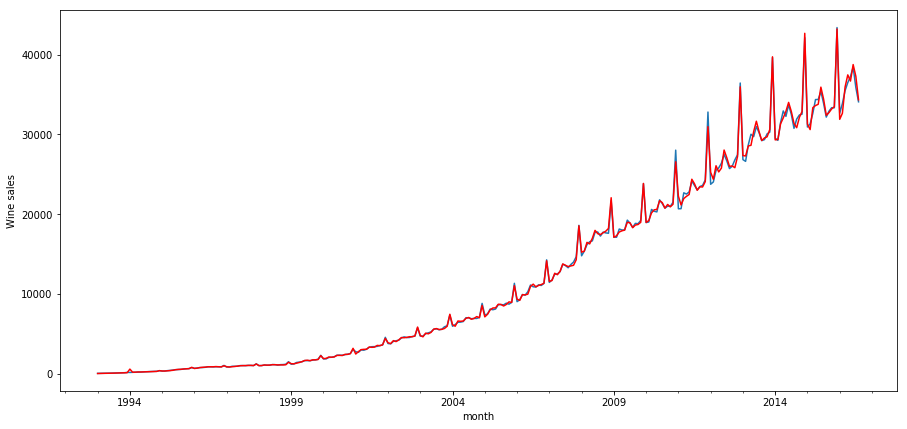

In [24]:
df['model'] = invboxcox(best_model.fittedvalues, 0) - best_model.resid.mean()
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

После коррекции по устранению смещенности, модель также хорошо описывает временной ряд.

# 7. Прогнозирование с помощью финальной модели.

In [25]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=284+35), 0) - best_model.resid.mean()

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

/Users/roman/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


Прогноз выглядит достаточно адекватным:
 - прогноз воспроизел сезонность ряда
 - Прогно не выглядит смещенным относительно ряда.
 - Прогноз уловил разворот тренда, что на первый взгляд выглядит удивительным, но объясняетя наличием отрицательных коэффициентов в авторегрессии и в сезонной авторегрессии. А также, если рассмотреть график разносте (расположенный ниже), то можно увидеть замедление кскорения исходного ряда (то есть скорость графика разностей) и даже начало разворота в двух последних сезонах.

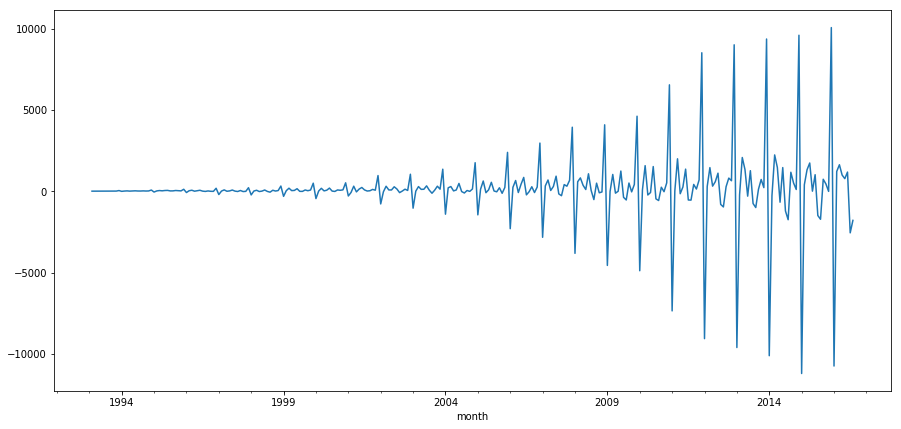

In [26]:
(df.WAG_C_M - df.WAG_C_M.shift(1))[1:].plot()